# Gaussian processes and Bayesian optimization

In this assignment you will learn how to use <a href="http://sheffieldml.github.io/GPy/">GPy</a> and <a href="http://sheffieldml.github.io/GPyOpt/">GPyOpt</a> libraries to deal with gaussian processes. These libraries provide quite simple and inuitive interfaces for training and inference, and we will try to get familiar with them in a few tasks.

### Installation
New libraries that are required for this tasks can be installed with the following command (if you use Anaconda):

```bash
pip install GPy 
pip install gpyopt 
pip install xgboost 
```

You can also follow installtaion guides from <a href="https://github.com/SheffieldML/GPy">GPy</a> and <a href="http://sheffieldml.github.io/GPyOpt/firststeps/index.html">GPyOpt</a> if you want to build them from source

You will also need following libraries: ```numpy```, ```scikit-learn```, ```matplotlib```

In [1]:
! conda install pyqt=4

Solving environment: - ^C
failed

CondaError: KeyboardInterrupt



In [ ]:
! pip install GPy

In [ ]:
! pip install gpyopt

In [ ]:
! pip install xgboost

In [12]:
import numpy as np
import GPy
import GPyOpt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import sklearn.datasets
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import time
from grader import Grader
%matplotlib inline

### Grading
We will create a grader instace below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to platform only after running submiting function in the last part of this assignment. If you want to make partial submission, you can run that cell any time you want.

In [13]:
grader = Grader()

## Gaussian processes: GPy (<a href="http://pythonhosted.org/GPy/">documentation</a>)

We will start with a simple regression problem, for which we will try to fit a Gaussian Process with RBF kernel.

In [14]:
def generate_points(n=25, noise_variance=0.0036):
    np.random.seed(777)
    X = np.random.uniform(-3.,3.,(n,1))
    y = np.sin(X) + np.random.randn(n,1)*noise_variance**0.5
    return X, y
    
def generate_noise(n=25, noise_variance=0.0036):
    np.random.seed(777)
    X = np.random.uniform(-3.,3.,(n,1))
    y = np.random.randn(n,1)*noise_variance**0.5
    return X, y

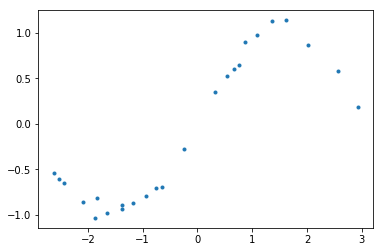

In [15]:
# Create data points
X, y = generate_points()
plt.plot(X, y, '.')
plt.show()

To fit a Gaussian Process, you will need to define a kernel. For Gaussian (GBF) kernel you can use *GPy.kern.RBF*
function.

<b> Task 1.1: </b> Create RBF kernel with variance 1.5 and length-scale parameter 2 for 1D samples and compute value of the kernel between 6-th and 10-th points (one-based indexing system). Submit a single number. 
<br><b>Hint:</b> use ```.K``` property of kernel object.

In [16]:
kernel = GPy.kern.RBF(input_dim=1, variance=1.5, lengthscale=2.) ### YOUR CODE HERE
kernel_59 = kernel.K_of_r(r=(X[9]-X[5]))
grader.submit_GPy_1(kernel_59)

Current answer for task 1.1 is: 0.354939330020383


<b> Task 1.2: </b> Fit GP into generated data. Use kernel from previous task. Submit predicted mean and vairance at position $x=1$.
<br><b>Hint:</b> use ```GPy.models.GPRegression``` class.

In [20]:
model = GPy.models.GPRegression(X,y,kernel)### YOUR CODE HERE
X_new = np.asarray([1]).reshape(1,1)
mean,variance = model.predict(X_new)
grader.submit_GPy_2(mean, variance)

Current answer for task 1.2 (mean) is: 0.6646774926102934
Current answer for task 1.2 (variance) is: 1.100147822379058


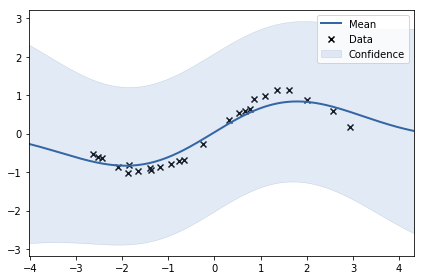

In [21]:
model.plot()
plt.show()

We see that model didn't fit the data quite well. Let's try to fit kernel and noise parameters automatically as discussed in the lecture! You can see current parameters below:

In [25]:
model


GP_regression.,value,constraints,priors
rbf.variance,1.5,+ve,
rbf.lengthscale,2.0,+ve,
Gaussian_noise.variance,1.0,+ve,


<b> Task 1.3: </b> Optimize length-scale, variance and noise component of the model and submit optimal length-scale value of the kernel. 
<br><b>Hint:</b> Use ```.optimize()``` function of the model and ```.lengthscale``` property of the kernel.

In [30]:
### YOUR CODE HERE
model.optimize(messages=True)
lengthscale = kernel.lengthscale
grader.submit_GPy_3(lengthscale)

Current answer for task 1.3 is: 1.6252681874740171


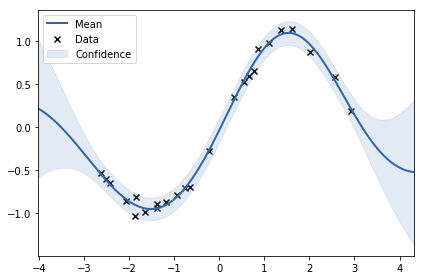

In [28]:
model.plot()
plt.show()

As you see, process generates outputs just right. Let's see if GP can figure out itself when we try to fit it into  noise or signal.

<b> Task 1.4: </b> Generate two datasets: sinusoid wihout noise and samples from gaussian noise. Optimize kernel parameters and submit optimal values of noise component.
<br><b>Note:</b> generate data only using ```generate_points(n, noise_variance)``` and ```generate_noise(n, noise_variance)``` function!

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fdc7028b898>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fdc7028bd68>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fdc7028b780>]]}

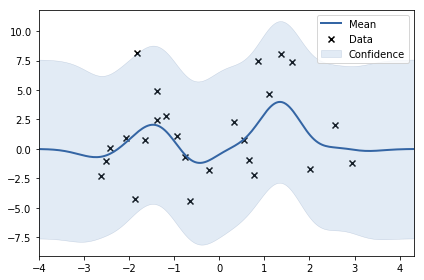

In [35]:
X, y = generate_noise(noise_variance=10)
### YOUR CODE HERE
model = GPy.models.GPRegression(X,y,kernel)
model.optimize(messages=True)
model.plot()

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fdc701dd828>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fdc701ddcc0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fdc701dd710>]]}

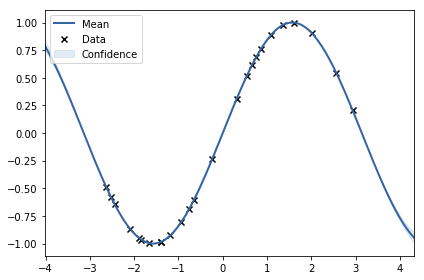

In [36]:
X, y = generate_points(noise_variance=0)
### YOUR CODE HERE
model = GPy.models.GPRegression(X,y,kernel)
model.optimize(messages=True)
model.plot()

In [37]:
noise =  10.143321842393293
just_signal = 1.4995254892476796e-14
grader.submit_GPy_4(noise, just_signal)

Current answer for task 1.4 (noise) is: 10.143321842393293
Current answer for task 1.4 (just signal) is: 1.4995254892476796e-14


#### Sparce GP
Now let's consider the speed of GP. We will generate a dataset of 3000 points and measure time that is consumed for prediction of mean and variance for each point. We will then try to use indusing inputs and find optimal number of points according to quality-time tradeoff.

For sparse model with inducing points you should use ```GPy.models.SparseGPRegression``` class. You can set number of inducing inputs with parameter ```num_inducing``` and optimize their positions and values with ```.optimize()``` call.

<b>Task 1.5</b>: Create a dataset of 1000 points and fit GPRegression. Measure time for predicting mean and variance at position $x=1$. Then fit SparseGPRegression with 10 inducing inputs and repeat the experiment. Report speedup as a ratio between consumed time without and with inducing inputs.

In [51]:
#Fit the full GP
X, y = generate_points(1000)
model = GPy.models.GPRegression(X,y,kernel)
model.optimize(messages=True)

In [52]:
#Measure time
X_new = np.array([1]).reshape(1,1)
start = time.time()
### YOUR CODE HERE
mean,var = model.predict(X_new)
time_gp = time.time()-start

In [53]:
#Fit Sparse GP with 10 inducing inputs
model_sp = GPy.models.SparseGPRegression(X,y,kernel=kernel,num_inducing=10)
model_sp.optimize(messages=True)

In [54]:
start = time.time()
### YOUR CODE HERE
mean,var = model_sp.predict(X_new)
time_sgp = time.time()-start

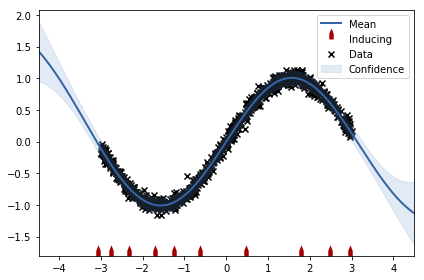

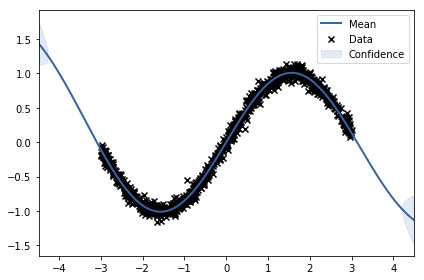

In [55]:
model_sp.plot()
model.plot()
plt.show()

In [56]:
grader.submit_GPy_5(time_gp / time_sgp)

Current answer for task 1.5 is: 3.3376060973497315


## Bayesian optimization: GPyOpt (<a href="http://pythonhosted.org/GPyOpt/">documentation</a>, <a href="http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/index.ipynb">tutorials</a>)

In this part of the assignment we will try to find optimal hyperparameters to XGBoost model! We will use data from a small competition to speed things up, but keep in mind that the approach works even for large datasets.

We will use diabetes dataset provided in sklearn package.

In [77]:
dataset = sklearn.datasets.load_diabetes()
X = dataset['data']
y = dataset['target']

We will use cross validation score to estimate accuracy and our goal will be to tune: ```max_depth```, ```learning_rate```, ```n_estimators``` parameters. The baseline MSE with default XGBoost parameters is $0.2$. Let's see if we can do better. First we have to define optimization function and domains.

In [78]:
# Score. Optimizer will try to find minimum, so we will add a "-" sign.
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              gamma=int(parameters[1]),
                              min_child_weight = parameters[4]), 
                X, y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

def f_svr(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
                SVR(gamma = parameters[0],
                    C = parameters[1],
                    epsilon = parameters[2]), 
                X, y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

In [79]:
baseline = -cross_val_score(XGBRegressor(), X, y, scoring='neg_mean_squared_error').mean()
baseline

3498.951701204653

In [80]:
# Bounds (NOTE: define continuous variables first, then discrete!)
bounds = [
            {'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
            {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
            {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
            {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}
         ]

In [81]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                                acquisition_type ='MPI',
                                                acquisition_par = 0.1,
                                                exact_eval=True)

In [82]:
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

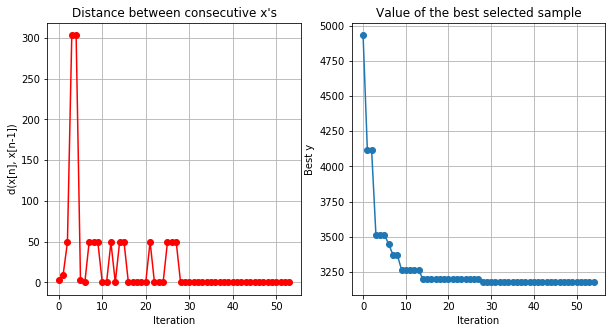

In [83]:
optimizer.plot_convergence()

Best values of parameters:

In [84]:
optimizer.X[np.argmin(optimizer.Y)]

array([5.94791898e-02, 1.32162893e+00, 1.00000000e+00, 3.00000000e+02,
       1.00000000e+00])

In [85]:
print('MSE:', np.min(optimizer.Y), 'Gain:', baseline/np.min(optimizer.Y)*100)

MSE: 3175.564212554564 Gain: 110.18362303528863


We were able to get 9% boost wihtout tuning parameters by hand! Let's see if you can do the same. 

<b>Task 2.1:</b> Tune SVR model. Find optimal values for three parameters: ```C```, ```epsilon``` and ```gamma```. Use range (1e-5, 1000) for ```C```, (1e-5, 10) for ```epsilon``` and ```gamma```. Use MPI as acquisition function with weight 0.1. Submit optimal value of epsilon that was found by a model.

In [89]:
bounds_svr = [
                {'name': 'gamma','type':'continuous','domain':(1e-5,10)},
                {'name': 'C','type':'continuous','domain':(1e-5,1000)},
                {'name': 'epsilon','type':'continuous','domain':(1e-5,10)}
             ]

In [90]:
#Compute baseline for SVR
baseline_svr = -cross_val_score(SVR(), X, y, scoring='neg_mean_squared_error').mean()
print(baseline_svr)

6067.652263997995


In [91]:
# Perform Bayesian Opt for hyper-params
np.random.seed(777)
optimizer_svr = GPyOpt.methods.BayesianOptimization(f=f_svr, domain=bounds_svr,
                                                    acquisition_type ='MPI',
                                                    acquisition_par = 0.1,
                                                    exact_eval=True)

In [93]:
max_iter = 50
max_time = 60
optimizer_svr.run_optimization(max_iter, max_time)

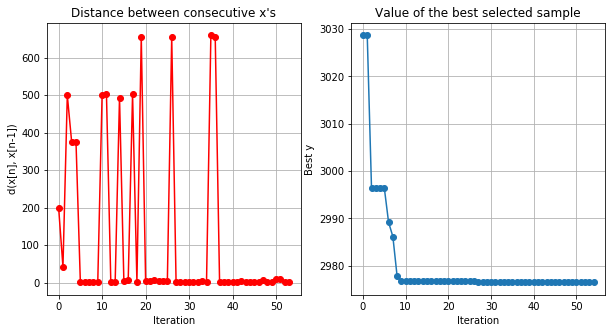

In [95]:
optimizer_svr.plot_convergence()

In [98]:
best_epsilon = optimizer_svr.X[np.argmin(optimizer_svr.Y)][2]

In [99]:
### YOUR CODE HERE
grader.submit_GPyOpt_1(best_epsilon)

Current answer for task 2.1 is: 4.756577122644031


<b>Task 2.2:</b> For the model above submit boost in improvement that you got after tuning hyperparameters (output percents) [e.g. if baseline MSE was 40 and you got 20, output number 200]

In [100]:
performance_boost = (baseline_svr/np.min(optimizer.Y))
print(performance_boost)
grader.submit_GPyOpt_2(performance_boost*100)

1.9107320330697728
Current answer for task 2.2 is: 191.0732033069773


### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [101]:
STUDENT_EMAIL = 'ishaan.bhat@ict.nl'
STUDENT_TOKEN = 'kbg18gFsemjDii5o'
grader.status()

You want to submit these numbers:
Task 1.1: 0.354939330020383
Task 1.2 (mean): 0.6646774926102934
Task 1.2 (variance): 1.100147822379058
Task 1.3: 1.6252681874740171
Task 1.4 (noise): 10.143321842393293
Task 1.4 (just signal): 1.4995254892476796e-14
Task 1.5: 3.3376060973497315
Task 2.1: 4.756577122644031
Task 2.2: 191.0732033069773


If you want to submit these answers, run cell below

In [102]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
